In [ ]:
!pip install catboost --no-cache-dir
!pip install numpy
!pip install pandas
!pip install --upgrade scikit-learn imbalanced-learn catboost
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.0



In [ ]:
!pip install imbalanced-learn

In [33]:
import pandas as pd

train_cleaned = pd.read_csv('D:/Code/intensiv/train_cleaned.csv', low_memory=False) 
valid_cleaned = pd.read_csv('D:/Code/intensiv/valid_cleaned.csv', low_memory=False) 


Дроп колонок

In [34]:
del valid_cleaned ['col2663']
del valid_cleaned ['col1454']

del train_cleaned ['col2663']
del train_cleaned ['col1454']

Заполнение

In [35]:
# Заполнение пропущенных значений
for col in valid_cleaned.columns:
    if valid_cleaned[col].dtype in ['float64', 'int64']:  # Если колонка числовая
        valid_cleaned[col] = valid_cleaned[col].fillna(valid_cleaned[col].median())
    elif valid_cleaned[col].dtype == 'object':  # Если колонка текстовая
        valid_cleaned[col] = valid_cleaned[col].fillna('unknown')

In [36]:
# Заполнение пропущенных значений
for col in train_cleaned.columns:
    if train_cleaned[col].dtype in ['float64', 'int64']:  # Если колонка числовая
        train_cleaned[col] = train_cleaned[col].fillna(train_cleaned[col].median())
    elif train_cleaned[col].dtype == 'object':  # Если колонка текстовая
        train_cleaned[col] = train_cleaned[col].fillna('unknown')

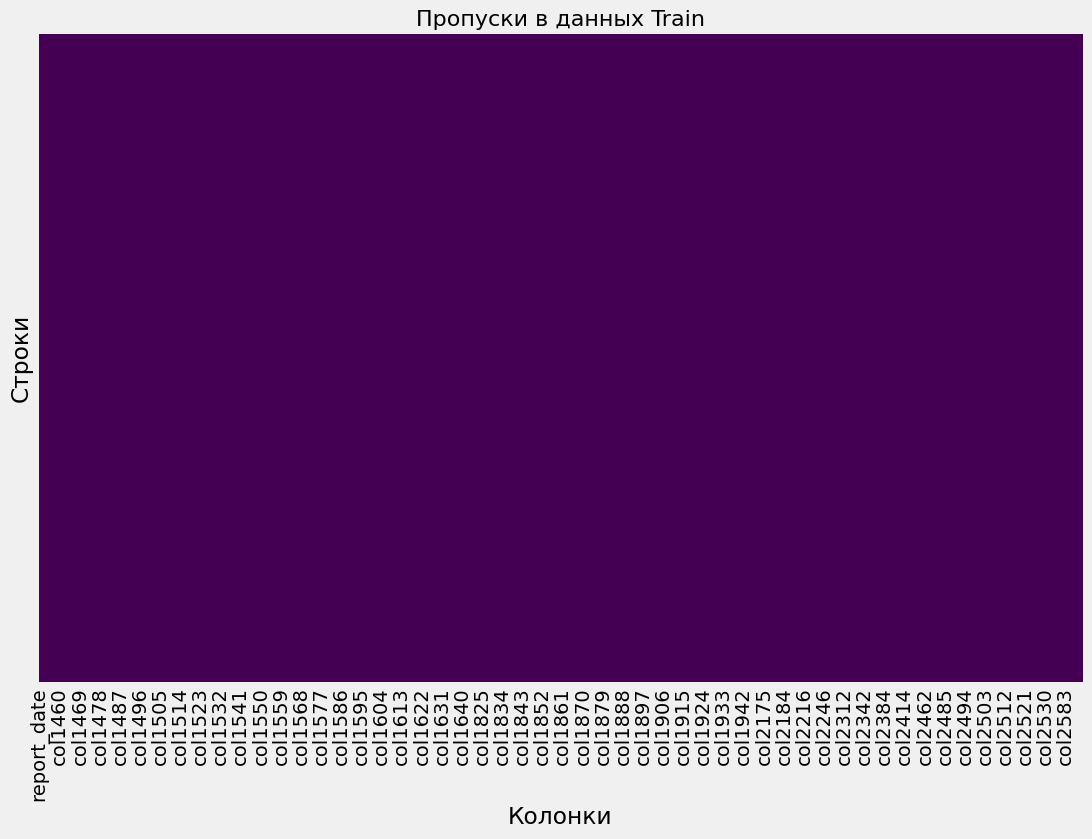

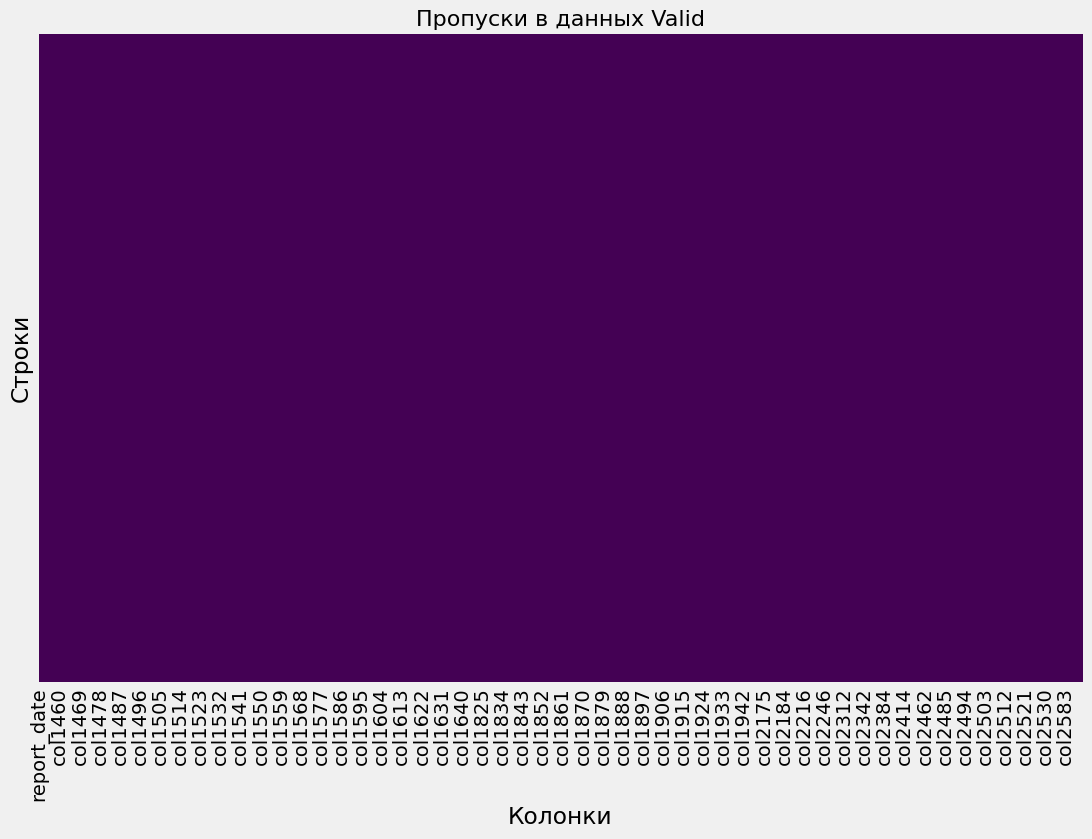

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Рассчитаем долю пропусков для каждого набора данных
train_missing_fraction = train_cleaned.isnull().mean()
valid_missing_fraction = valid_cleaned.isnull().mean()

# Рассчитаем максимальную долю пропусков для каждой колонки между train и valid
combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)

# Визуализация пропусков в train
plt.figure(figsize=(12, 8))
sns.heatmap(train_cleaned.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Train", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

# Визуализация пропусков в valid
plt.figure(figsize=(12, 8))
sns.heatmap(valid_cleaned.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Valid", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()


In [38]:
train_cleaned

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2022-11-01,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
1,2022-11-01,5,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,5903704.0,362.0,362.0,362.0,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0
2,2022-05-01,6,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
3,2022-09-01,7,0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
4,2022-08-01,8,0,0,0.0,0.0,0.0,0.0,0.0,4.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,0,0.0,0.0,0.0,0.0,2.0,2.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14452,2022-09-01,1969,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14453,2022-02-01,7116,1,0,0.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14454,2021-08-01,7117,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0


In [39]:
valid_cleaned

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2023-04-01,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,4981252.0,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0
1,2023-05-01,4,0,0,0.0,0.0,1.0,1.0,1.0,1.0,...,11789500.0,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0
2,2023-05-01,9,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0
3,2023-03-01,12,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
4,2023-03-01,14,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,10391000.0,360.0,360.0,360.0,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,2023-04-01,4366,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3500000.0,360.0,360.0,360.0,360.0,360.0,360.0,3500000.0,3500000.0,3500000.0
3638,2023-04-01,8298,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3639,2023-03-01,835,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3640,2023-03-01,8300,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5


Обучение модели №2 с помощью CatBoostClassifier

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Загрузка данных
X = train_cleaned.drop(columns=['client_id', 'target', 'report_date'])
y = train_cleaned['target']

# Определение числовых и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Преобразование категориальных данных в строковый формат
X[categorical_features] = X[categorical_features].astype(str)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание и обучение модели CatBoost
catboost_model = CatBoostClassifier(
    iterations=500,           # Количество итераций
    learning_rate=0.05,       # Темп обучения
    depth=8,                  # Глубина деревьев
    random_state=42,
    cat_features=categorical_features,  # Указываем категориальные признаки как список
    verbose=50,               # Вывод промежуточных результатов
    auto_class_weights='Balanced'       # Балансировка классов
)

# Обучение модели
catboost_model.fit(X_train, y_train)


# Предсказание вероятностей
test_preds = catboost_model.predict_proba(X_test)[:, 1]

# Оценка модели с помощью ROC-AUC
test_score = roc_auc_score(y_test, test_preds)
print(f"ROC-AUC на тестовых данных: {test_score:.4f}")

# Сохранение результатов
submission = pd.DataFrame({'client_id': train_cleaned.loc[X_test.index, 'client_id'], 'score': test_preds})
submission.to_csv('submission_catboost.csv', index=False)

print("Результаты сохранены в submission_catboost.csv")


0:	learn: 0.6669328	total: 353ms	remaining: 2m 56s
50:	learn: 0.3292430	total: 5.59s	remaining: 49.2s
100:	learn: 0.2442775	total: 11.1s	remaining: 44s
150:	learn: 0.1881098	total: 17s	remaining: 39.4s
200:	learn: 0.1314515	total: 22.7s	remaining: 33.8s
250:	learn: 0.0871486	total: 28.7s	remaining: 28.4s
300:	learn: 0.0596308	total: 33.9s	remaining: 22.4s
350:	learn: 0.0449570	total: 39.3s	remaining: 16.7s
400:	learn: 0.0343882	total: 44.9s	remaining: 11.1s
450:	learn: 0.0277558	total: 50.3s	remaining: 5.46s
499:	learn: 0.0234603	total: 55.9s	remaining: 0us
ROC-AUC на тестовых данных: 0.9304
Результаты сохранены в submission_catboost.csv


Применение модели

In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Загрузка valid_cleaned
X_valid = valid_cleaned.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_cleaned['target']

# Преобразование категориальных данных

# Убедимся, что категории соответствуют обучающим данным
X_valid[categorical_features] = X_valid[categorical_features].astype(str)

# Предсказание на valid_cleaned

# Используем уже обученную модель catboost_model
valid_preds = catboost_model.predict_proba(X_valid)[:, 1]

# Оценка ROC-AUC на valid данных
valid_score = roc_auc_score(y_valid, valid_preds)
print(f"ROC-AUC на valid данных: {valid_score:.4f}")

# Сохранение результатов

submission_valid = pd.DataFrame({
    'client_id': valid_cleaned['client_id'],
    'score': valid_preds
})

submission_valid.to_csv('submission_valid_catboost.csv', index=False)
print("Результаты сохранены в submission_valid_catboost.csv")


ROC-AUC на valid данных: 0.6695
Результаты сохранены в submission_valid_catboost.csv


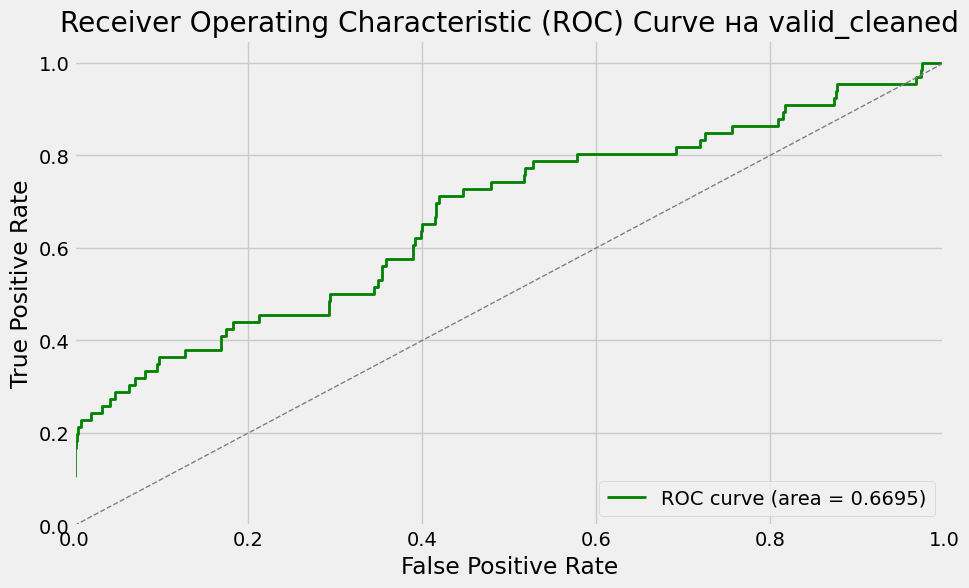

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, valid_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve на valid_cleaned')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Подготовка к обучению третьей модели

Дроп дубликатов, пропуская report_date, client_id и target

In [43]:
columns_to_check = train_cleaned.columns.difference(['report_date', 'client_id', 'target'])

train_no_duplicates = train_cleaned.drop_duplicates(subset=columns_to_check)

print("\nТаблица без дубликатов по указанным колонкам:")
print(train_no_duplicates)



Таблица без дубликатов по указанным колонкам:
      report_date  client_id  target  col1453  col1455  col1456  col1457  \
0      2022-11-01          1       0        0      0.0      0.0      0.0   
1      2022-11-01          5       0        1      0.0      0.0      0.0   
2      2022-05-01          6       0        0      0.0      0.0      0.0   
3      2022-09-01          7       0        0      1.0      1.0      1.0   
4      2022-08-01          8       0        0      0.0      0.0      0.0   
...           ...        ...     ...      ...      ...      ...      ...   
14451  2022-07-01       1241       0        0      0.0      0.0      0.0   
14452  2022-09-01       1969       1        0      0.0      0.0      0.0   
14453  2022-02-01       7116       1        0      0.0      1.0      1.0   
14454  2021-08-01       7117       0        0      0.0      0.0      0.0   
14455  2022-03-01        849       0        0      0.0      0.0      1.0   

       col1458  col1459  col1460  ...   

In [44]:
train_no_duplicates

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2022-11-01,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
1,2022-11-01,5,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,5903704.0,362.0,362.0,362.0,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0
2,2022-05-01,6,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
3,2022-09-01,7,0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
4,2022-08-01,8,0,0,0.0,0.0,0.0,0.0,0.0,4.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,0,0.0,0.0,0.0,0.0,2.0,2.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14452,2022-09-01,1969,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14453,2022-02-01,7116,1,0,0.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14454,2021-08-01,7117,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0


Дроп дубликатов, пропуская report_date, client_id и target

In [45]:
columns_to_check = valid_cleaned.columns.difference(['report_date', 'client_id', 'target'])

valid_no_duplicates = valid_cleaned.drop_duplicates(subset=columns_to_check)

print("\nТаблица без дубликатов по указанным колонкам:")
print(valid_no_duplicates)



Таблица без дубликатов по указанным колонкам:
     report_date  client_id  target  col1453  col1455  col1456  col1457  \
0     2023-04-01          2       0        0      0.0      0.0      0.0   
1     2023-05-01          4       0        0      0.0      0.0      1.0   
2     2023-05-01          9       0        0      0.0      0.0      0.0   
3     2023-03-01         12       0        0      0.0      0.0      0.0   
4     2023-03-01         14       0        0      0.0      0.0      0.0   
...          ...        ...     ...      ...      ...      ...      ...   
3637  2023-04-01       4366       0        0      0.0      0.0      0.0   
3638  2023-04-01       8298       0        0      0.0      0.0      0.0   
3639  2023-03-01        835       0        0      0.0      0.0      0.0   
3640  2023-03-01       8300       0        0      0.0      0.0      0.0   
3641  2023-05-01       1974       1        0      0.0      0.0      0.0   

      col1458  col1459  col1460  ...     col2566  co

In [46]:
valid_no_duplicates

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2023-04-01,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,4981252.0,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0
1,2023-05-01,4,0,0,0.0,0.0,1.0,1.0,1.0,1.0,...,11789500.0,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0
2,2023-05-01,9,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0
3,2023-03-01,12,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
4,2023-03-01,14,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,10391000.0,360.0,360.0,360.0,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,2023-04-01,4366,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3500000.0,360.0,360.0,360.0,360.0,360.0,360.0,3500000.0,3500000.0,3500000.0
3638,2023-04-01,8298,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3639,2023-03-01,835,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3640,2023-03-01,8300,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5


Проверка на дисбаланс

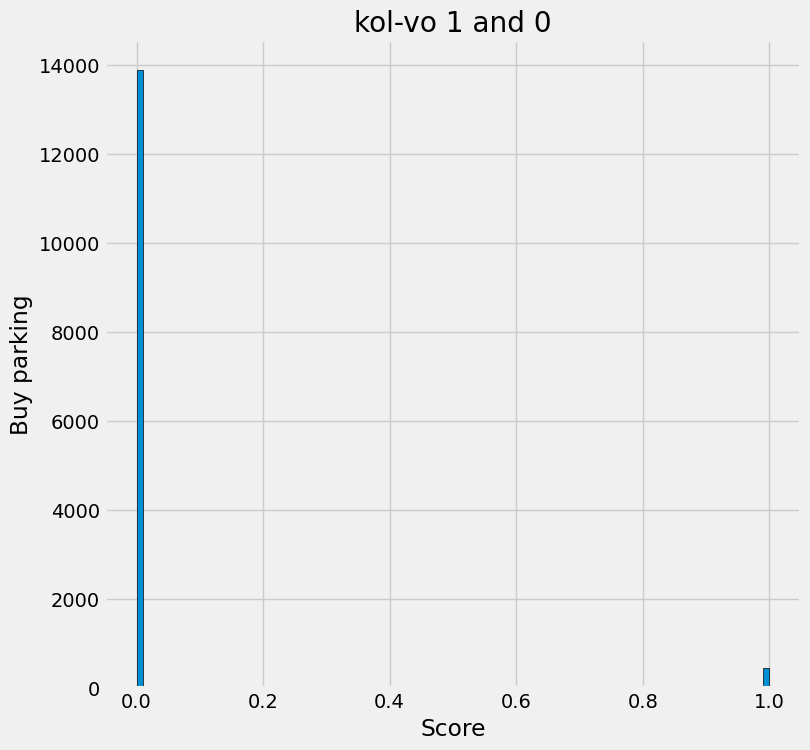

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

data = train_no_duplicates.rename(columns={'target': 'score'})

plt.style.use('fivethirtyeight')  # Стиль графика
plt.hist(data['score'].dropna(), bins=100, edgecolor='k')  # Построение гистограммы
plt.xlabel('Score')  # Подпись оси X
plt.ylabel('Buy parking')  # Подпись оси Y
plt.title('kol-vo 1 and 0')  # Заголовок графика

# Показать график
plt.show()

In [48]:
print(y.value_counts(normalize=True))


target
0    0.96984
1    0.03016
Name: proportion, dtype: float64


значение 1 встречается всего 3%, явный дисбаланс

Смотрим, есть ли колонки, которые слшиком сильно влияют на обучение

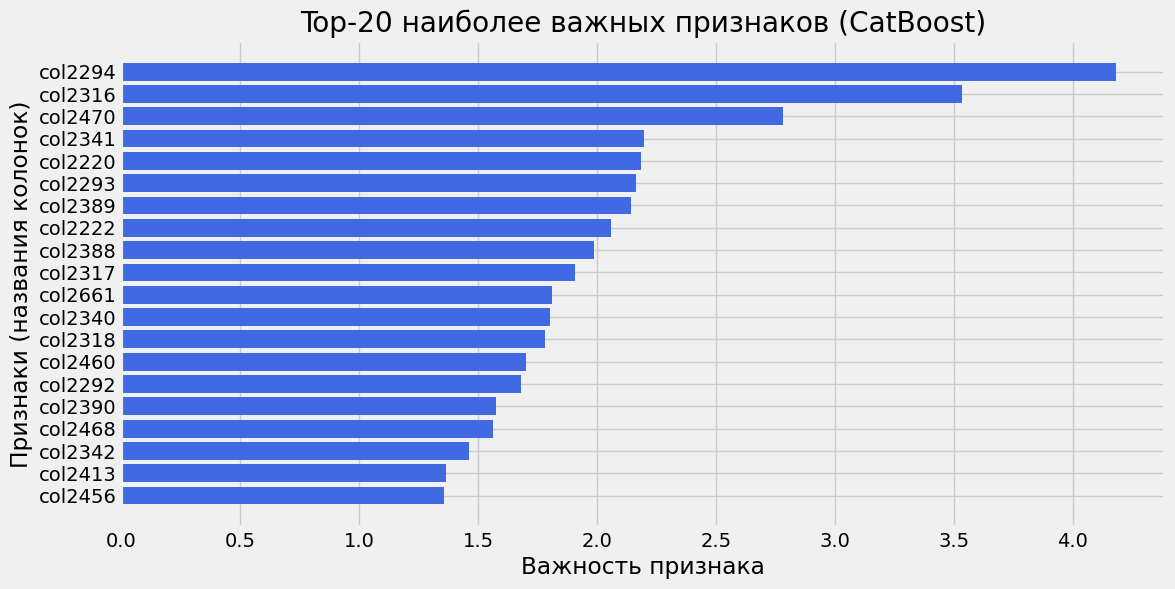

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Получение важностей признаков из обученной модели
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,                      # Названия колонок из X_train
    'Importances': catboost_model.get_feature_importance()  # Важности признаков из CatBoost
})

# Сортировка признаков по важности
top_features = feature_importance.sort_values(by="Importances", ascending=False).head(20)

# Построение графика
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importances'], color='royalblue')
plt.gca().invert_yaxis()  # Инвертируем ось для наглядности
plt.title("Top-20 наиболее важных признаков (CatBoost)")
plt.xlabel("Важность признака")
plt.ylabel("Признаки (названия колонок)")
plt.show()


Проверка информации двух самых важных колонок

In [50]:
feature_importance = catboost_model.get_feature_importance(prettified=True)
print(feature_importance)


    Feature Id  Importances
0      col2294     4.181074
1      col2316     3.533617
2      col2470     2.781076
3      col2341     2.198967
4      col2220     2.185616
..         ...          ...
459    col2530     0.000000
460    col2531     0.000000
461    col2532     0.000000
462    col2533     0.000000
463    col2534     0.000000

[464 rows x 2 columns]


In [51]:
valid_no_duplicates.col2294

0        5.000000
1        3.333333
2       21.000000
3        5.000000
4       14.000000
          ...    
3637     2.000000
3638     7.000000
3639    14.000000
3640     3.000000
3641     2.800000
Name: col2294, Length: 3631, dtype: float64

Уравниваем данные, чтобы не было дисбаланса в классе с помощью SMOTE

In [52]:
from sklearn.preprocessing import OrdinalEncoder


categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

X_train[categorical_columns] = X_train[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns] = encoded_data.astype(int)


categorical_columns = X_test.select_dtypes(include=['object']).columns.tolist()

X_test[categorical_columns] = X_test[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_test[categorical_columns])
X_test[categorical_columns] = encoded_data.astype(int)

Баланс классов в сбалансированной обучающей выборке:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


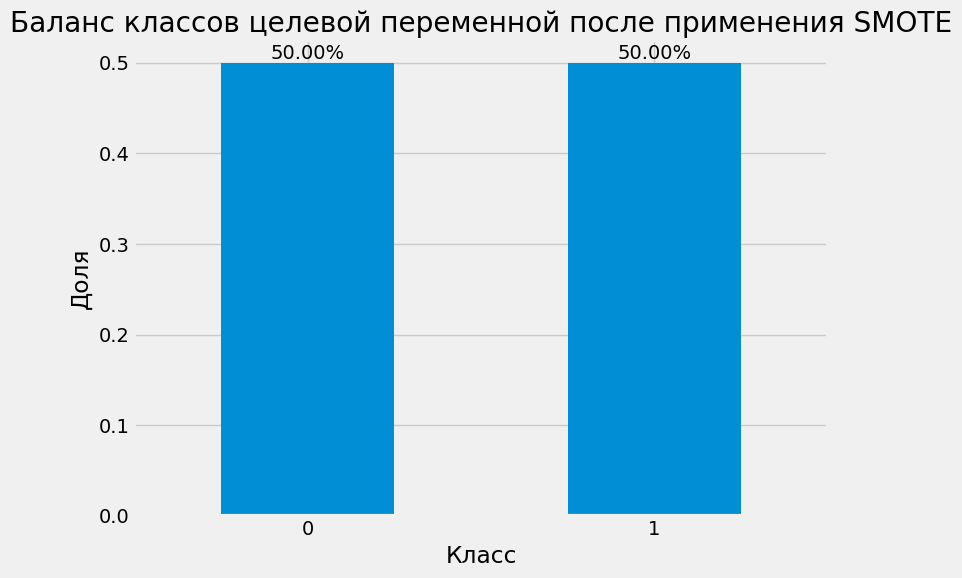

In [53]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Создание объекта SMOTE
smote = SMOTE(random_state=42)

# Применение SMOTE к обучающей выборке
X_train, y_train = smote.fit_resample(X_train, y_train)

# Проверка нового баланса классов
class_balance_balanced = y_train.value_counts(normalize=True)
print("Баланс классов в сбалансированной обучающей выборке:")
print(class_balance_balanced)

# Визуализация нового баланса классов
plt.figure(figsize=(8, 6))
class_balance_balanced.plot(kind='bar')
plt.title('Баланс классов целевой переменной после применения SMOTE')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance_balanced):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Классы равны

Обучение моделей после полной очистки и устранения дисбалансов в классе

Обучение модели №3 с помощью RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Подготовка данных
X_new = train_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = train_no_duplicates['target']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

# Кодирование категориальных признаков
categorical_columns = X_train.select_dtypes(include=['object']).columns
ordinal_encoder = OrdinalEncoder()
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns].astype(str))
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns].astype(str))

# Создание модели и Pipeline
random_forest_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1  # Параллельное выполнение
)

# Pipeline с SMOTE и Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Балансировка классов
    ('rf', random_forest_model)         # Обучение модели
])

# RandomizedSearchCV для поиска параметров
param_distributions = {
    'rf__n_estimators': [100, 200, 300, 500],       # Количество деревьев
    'rf__max_depth': [None, 10, 20, 30, 50],       # Максимальная глубина дерева
    'rf__min_samples_split': [2, 5, 10],           # Минимальное количество выборок для разбиения узла
    'rf__min_samples_leaf': [1, 2, 4],             # Минимальное количество выборок в листе
    'rf__class_weight': [None, 'balanced']         # Взвешивание классов
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,  # Количество случайных комбинаций
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1  # Использовать все ядра процессора
)

# Обучение модели
random_search.fit(X_train, y_train)

# Оценка на тестовых данных
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Лучшие параметры модели:", random_search.best_params_)
print("\nROC-AUC на тестовых данных:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report на тестовых данных:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры модели: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 30, 'rf__class_weight': 'balanced'}

ROC-AUC на тестовых данных: 0.9493966967489579

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2774
           1       0.82      0.43      0.56        87

    accuracy                           0.98      2861
   macro avg       0.90      0.71      0.78      2861
weighted avg       0.98      0.98      0.98      2861




ROC-AUC на valid данных: 0.7915466020655362

Classification Report на valid данных:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3565
           1       1.00      0.09      0.17        66

    accuracy                           0.98      3631
   macro avg       0.99      0.55      0.58      3631
weighted avg       0.98      0.98      0.98      3631



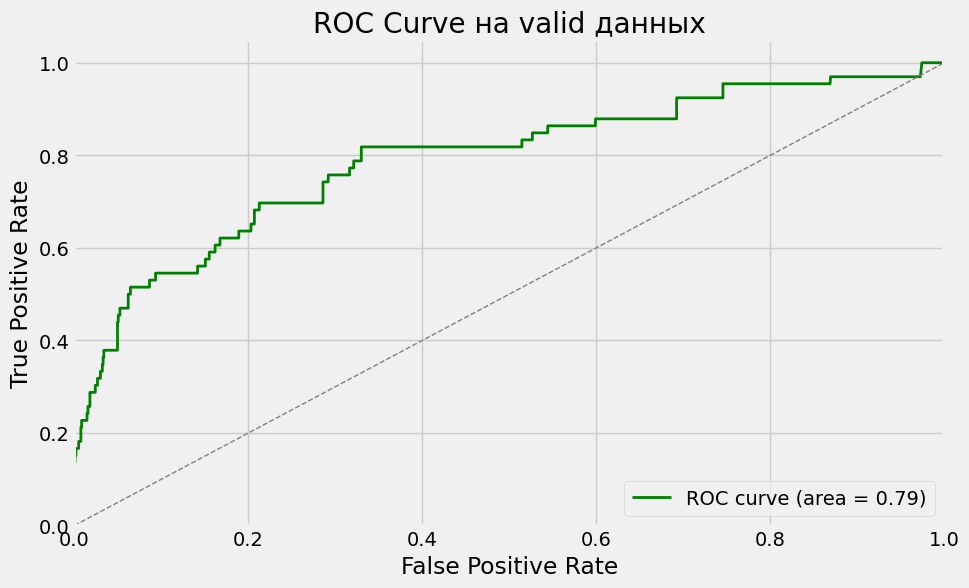

In [55]:

X_valid = valid_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_no_duplicates['target']

# Кодирование категориальных признаков
X_valid[categorical_columns] = ordinal_encoder.transform(X_valid[categorical_columns].astype(str))

# Предсказание на valid_no_duplicates
y_valid_pred = best_model.predict(X_valid)
y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Оценка модели на valid
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("\nROC-AUC на valid данных:", roc_auc_valid)
print("\nClassification Report на valid данных:\n", classification_report(y_valid, y_valid_pred))

# Визуализация ROC-AUC
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
roc_auc_valid_curve = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(10, 6))
plt.plot(fpr_valid, tpr_valid, color='green', lw=2, label=f'ROC curve (area = {roc_auc_valid_curve:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на valid данных')
plt.legend(loc="lower right")
plt.show()


Обучение модели №4 с помощью CatBoostClassifier

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Загрузка данных
X = train_no_duplicates.drop(columns=['client_id', 'target', 'report_date'])
y = train_no_duplicates['target']

# Определение числовых и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Преобразование категориальных данных в строковый формат
X[categorical_features] = X[categorical_features].astype(str)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание и обучение модели CatBoost
catboost_model = CatBoostClassifier(
    iterations=500,            # Количество итераций
    learning_rate=0.05,        # Темп обучения
    depth=8,                   # Глубина деревьев
    random_state=42,
    verbose=50                 # Вывод промежуточных результатов
)

# Обучение модели
catboost_model.fit(X_train, y_train)


# Предсказание вероятностей
test_preds = catboost_model.predict_proba(X_test)[:, 1]

# Оценка модели с помощью ROC-AUC
test_score = roc_auc_score(y_test, test_preds)
print(f"ROC-AUC на тестовых данных: {test_score:.4f}")

# Сохранение результатов
submission = pd.DataFrame({'client_id': train_no_duplicates.loc[X_test.index, 'client_id'], 'score': test_preds})
submission.to_csv('submission_catboost.csv', index=False)

print("Результаты сохранены в submission_catboost_2.csv")



0:	learn: 0.6085672	total: 236ms	remaining: 1m 57s
50:	learn: 0.1003862	total: 6.05s	remaining: 53.3s
100:	learn: 0.0750782	total: 11.3s	remaining: 44.6s
150:	learn: 0.0626291	total: 16.4s	remaining: 37.9s
200:	learn: 0.0547750	total: 21.7s	remaining: 32.3s
250:	learn: 0.0466246	total: 27s	remaining: 26.8s
300:	learn: 0.0396049	total: 32s	remaining: 21.1s
350:	learn: 0.0343908	total: 36.9s	remaining: 15.7s
400:	learn: 0.0310942	total: 42.7s	remaining: 10.5s
450:	learn: 0.0282862	total: 48.5s	remaining: 5.27s
499:	learn: 0.0254028	total: 53.4s	remaining: 0us
ROC-AUC на тестовых данных: 0.9468
Результаты сохранены в submission_catboost_2.csv


In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# Загрузка valid_no_duplicates
X_valid = valid_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_no_duplicates['target']

# Преобразование категориальных данных

# Убедимся, что категории соответствуют обучающим данным
X_valid[categorical_features] = X_valid[categorical_features].astype(str)

# Предсказание на valid_no_duplicates

# Используем уже обученную модель catboost_model
valid_preds = catboost_model.predict_proba(X_valid)[:, 1]

# Оценка ROC-AUC на valid данных
valid_score = roc_auc_score(y_valid, valid_preds)
print(f"ROC-AUC на valid данных: {valid_score:.4f}")

# Сохранение результатов
submission_valid = pd.DataFrame({
    'client_id': valid_no_duplicates['client_id'],
    'score': valid_preds
})

submission_valid.to_csv('submission_valid_no_duplicates_catboost.csv', index=False)
print("Результаты сохранены в submission_valid_no_duplicates_catboost.csv")


ROC-AUC на valid данных: 0.7389
Результаты сохранены в submission_valid_no_duplicates_catboost.csv


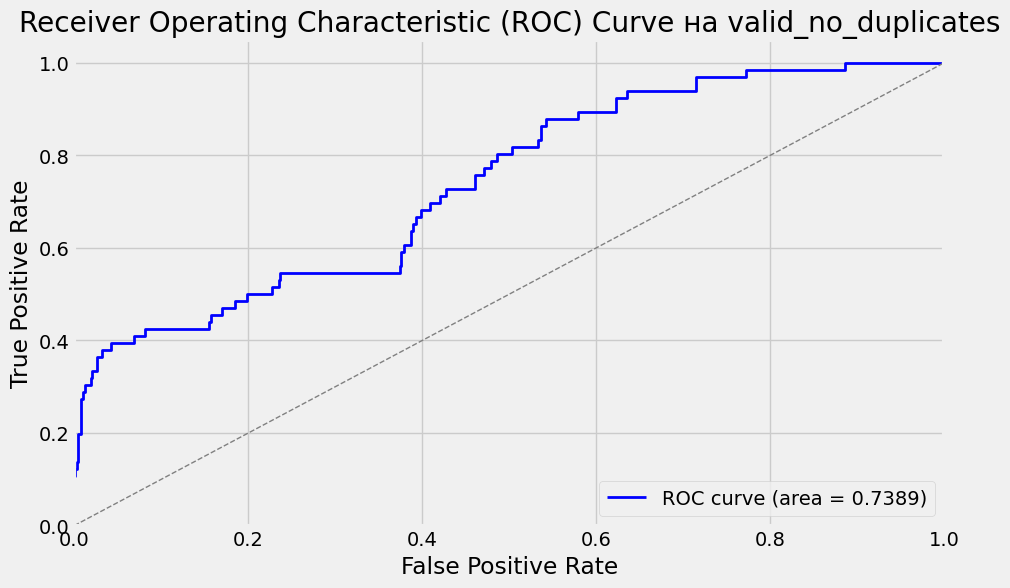

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, valid_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve на valid_no_duplicates')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Вывод

Обучение модели №3 с помощью RandomForestClassifier оказалась самая точная